In [66]:
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline import CustomFactor, CustomFilter, Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.classifiers.fundamentals import Sector 
import pandas as pd
import statsmodels.tsa.stattools as ts
from quantopian.pipeline.filters.morningstar import Q500US
from quantopian.pipeline import Pipeline
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from quantopian.pipeline import CustomFilter
from quantopian.pipeline.experimental import QTradableStocksUS
from quantopian.pipeline.data.psychsignal import stocktwits
import quantopian.pipeline.factors as factor


In [67]:
def normalize_multiarray(multyarray):
    
    # Si en caso el array es multiarray, lo transponemos
    if multyarray.shape[0] != 1:
        multyarray = multyarray.transpose()
        
    multiarray_normalized = []
        
    for array in multyarray:
        # Normalizamos el array obviando los nans (los dejamos como tal)
        array_normalized = array / np.linalg.norm(array[~np.isnan(array)])
        multiarray_normalized.append(array_normalized)
        
    multiarray_normalized = np.array(multiarray_normalized)
    
    # Si en caso el array es multiarray, lo transponemos
    if multyarray.shape[0] != 1:
        multiarray_normalized = multiarray_normalized.transpose()
    
    return multiarray_normalized

In [68]:
class abs_factor(CustomFactor):
    window_length = 1
    def compute(self, today, asset_ids, out, info):
        out[:] = np.abs(info)

In [69]:
def make_pipeline():
    universe = QTradableStocksUS()
    
    daily_returns = factor.DailyReturns([USEquityPricing.close])
    abs_daily_returns = abs_factor([daily_returns])
    
    volumen = USEquityPricing.volume.latest
    
    sentiment_score = stocktwits.bull_minus_bear.latest
    
    rsi_15 = factor.RSI([USEquityPricing.close])
    
    return Pipeline(columns={"volumen": volumen, 
                            "sentiment_score": sentiment_score,
                            "abs_daily_returns": abs_daily_returns,
                            "rsi_15": rsi_15}, screen=universe)

In [70]:
# Import run_pipeline method
from quantopian.research import run_pipeline

# Specify a time range to evaluate
period_start = '2019-01-25'
period_end = '2019-07-30'

# Execute pipeline over evaluation period
pipeline_output = run_pipeline(make_pipeline(), start_date=period_start, end_date=period_end)

In [71]:
sym = symbols('AAPL')

In [72]:
69.133802 % 50 +50

69.133802

In [89]:
from sklearn import preprocessing

one_stock_info = pipeline_output.xs(sym, level=1, drop_level=False)


# Nomalizando Volumen
volumen = one_stock_info.volumen #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
volumen_scaled = min_max_scaler.fit_transform(volumen)
one_stock_info["normalized_volumen"] = volumen_scaled

# Creando RSI 50 - 100
one_stock_info["rsi_50_100"] = one_stock_info.apply(lambda row:
                                                    abs(row.rsi_15 - 50) + 50, axis = 1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [90]:
one_stock_info

,,abs_daily_returns,rsi_15,sentiment_score,volumen,normalized_volumen,rsi_50_100
2019-01-25 00:00:00+00:00,Equity(24 [AAPL]),0.008183,69.133802,-0.090652,19094506.0,0.261980,69.133802
2019-01-28 00:00:00+00:00,Equity(24 [AAPL]),0.032807,67.781955,0.080941,27539414.0,0.455419,67.781955
2019-01-29 00:00:00+00:00,Equity(24 [AAPL]),0.009003,65.207957,-0.190369,19988982.0,0.282469,65.207957
2019-01-30 00:00:00+00:00,Equity(24 [AAPL]),0.010633,57.316889,-0.095655,28178841.0,0.470065,57.316889
2019-01-31 00:00:00+00:00,Equity(24 [AAPL]),0.068560,67.292863,-0.086785,50594128.0,0.983510,67.292863
2019-02-01 00:00:00+00:00,Equity(24 [AAPL]),0.006233,67.796997,-0.121781,28613432.0,0.480020,67.796997
2019-02-04 00:00:00+00:00,Equity(24 [AAPL]),0.001564,71.096109,-0.174604,23382409.0,0.360198,71.096109
2019-02-05 00:00:00+00:00,Equity(24 [AAPL]),0.028463,79.372792,0.207076,24807917.0,0.392851,79.372792
2019-02-06 00:00:00+00:00,Equity(24 [AAPL]),0.016524,79.240985,-0.050982,29214061.0,0.493778,79.240985
2019-02-07 00:00:00+00:00,Equity(24 [AAPL]),0.001034,78.218284,-0.013242,22445674.0,0.338742,78.218284


In [75]:
def plot_correlation_levels(factor_1, factor_1_name, factor_2, factor_2_name, paso = 5):
    lista = []

    for i in range(1, factor_1.shape[0], paso):
        correlacion = np.corrcoef(factor_1.values[i:i + paso], factor_2.values[i:i + paso])
        lista.append(correlacion[0,1])

    plt.title('Correlacion entre {} y {}, agrupado en grupos de {}'.format(factor_1_name, factor_2_name, paso))

    plt.plot(lista)

In [76]:
def plot_two(factor_1, factor_1_name, factor_2, factor_2_name):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(np.array(factor_1), color = "g")
    ax1.tick_params(axis='y', labelcolor="g")
    ax1.set_ylabel(factor_1_name, color="g")

    ax2.plot(np.array(factor_2), color = "r")
    ax2.tick_params(axis='y', labelcolor="r")
    ax2.grid(False)
    ax2.set_ylabel(factor_2_name, color="r")
    
    plt.title('{} vs {}'.format(factor_1_name, factor_2_name))
    plt.show()

    plot_correlation_levels(factor_1, factor_1_name, factor_2, factor_2_name)


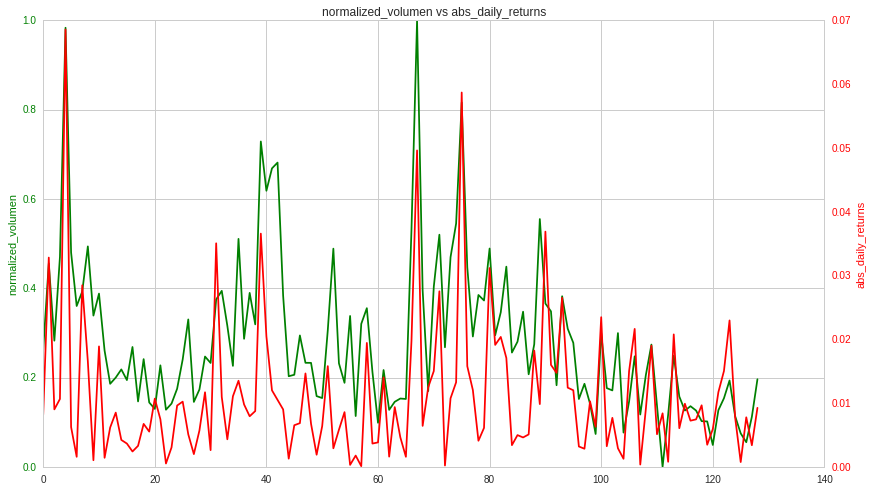

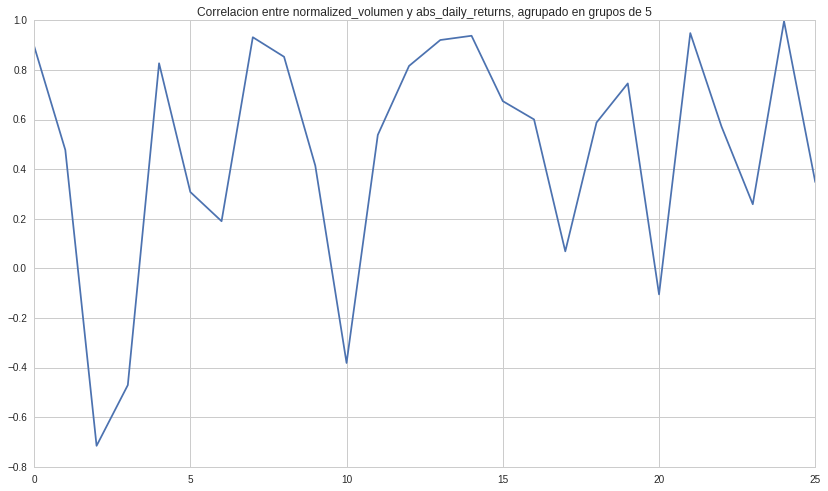

In [77]:
plot_two(one_stock_info.normalized_volumen, "normalized_volumen", 
         one_stock_info.abs_daily_returns, "abs_daily_returns")

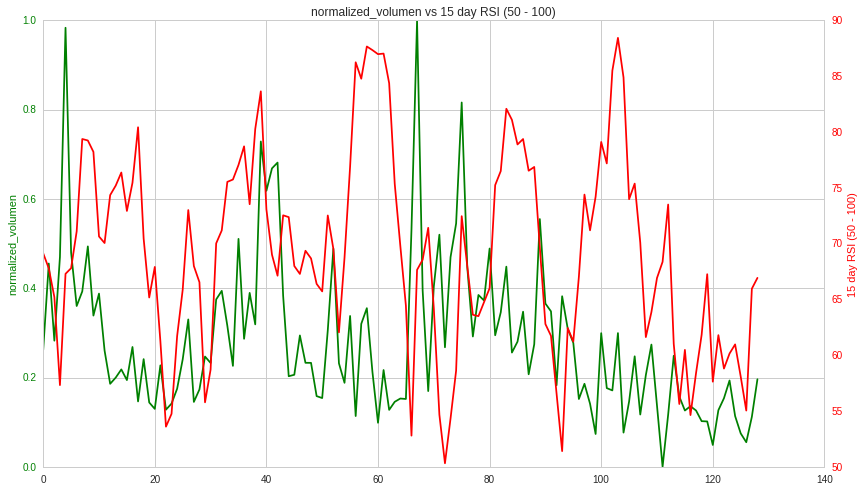

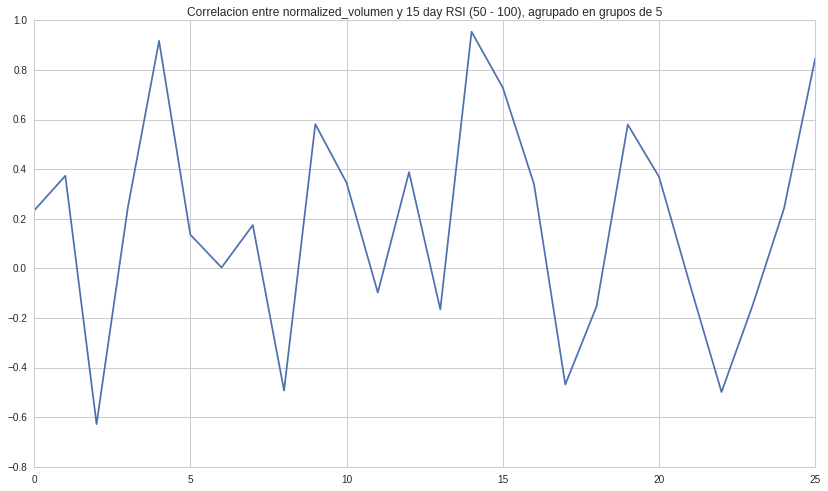

In [93]:
plot_two(one_stock_info.normalized_volumen, "normalized_volumen",
         one_stock_info.rsi_50_100, "15 day RSI (50 - 100)")

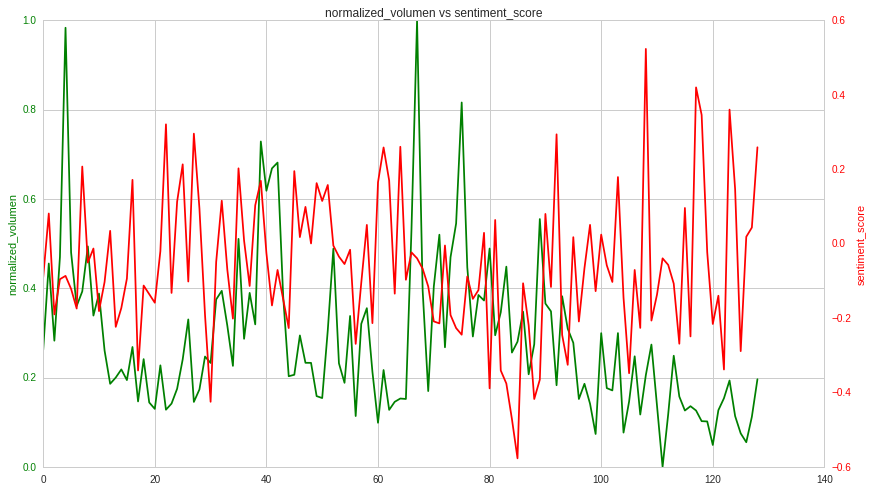

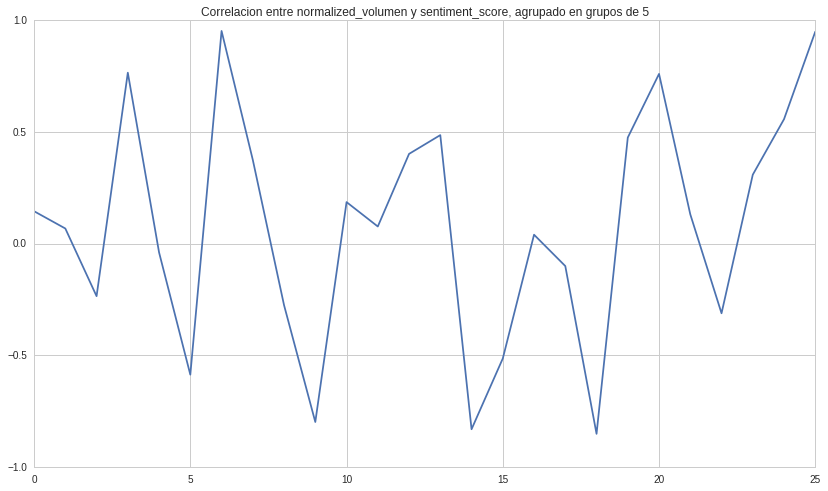

In [94]:
plot_two(one_stock_info.normalized_volumen, "normalized_volumen",
         one_stock_info.sentiment_score, "sentiment_score")

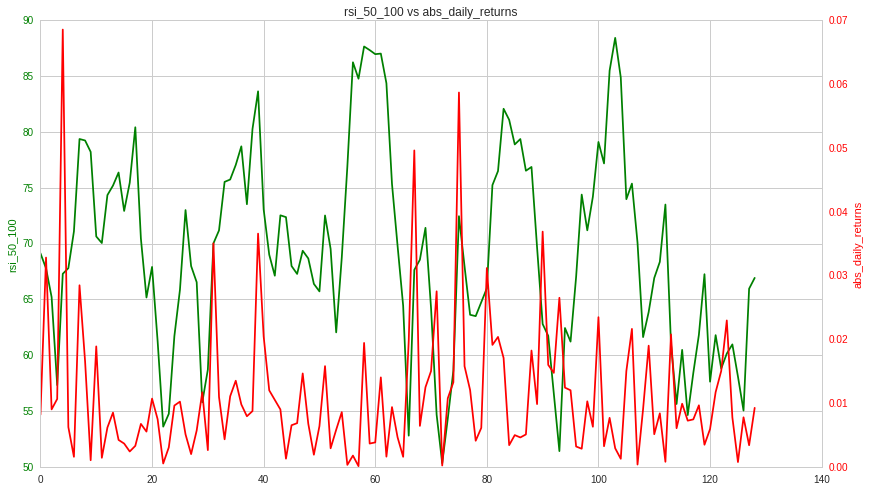

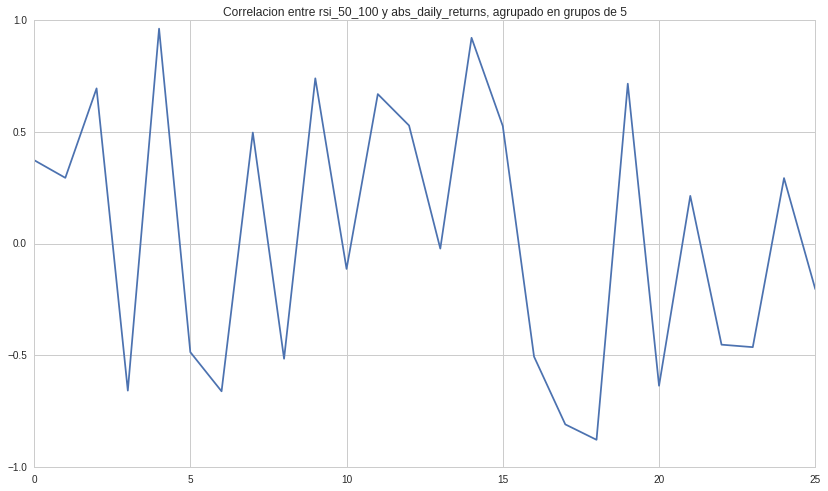

In [96]:
plot_two(one_stock_info.rsi_50_100, "rsi_50_100",
         one_stock_info.abs_daily_returns, "abs_daily_returns")